In [ ]:
class Variable:
    def __init__(self, data, _children=(), _op=''):
        self.data = data  # The value of this variable
        self.grad = 0  # The gradient of this variable, initialized to 0
        self._backward = lambda: None  # Function for backpropagation
        self._children = set(_children)  # Set of parent Variables
        self._op = _op  # Operation that created this variable (e.g., '+', '*')

    def __repr__(self):
        return f"Variable(data={self.data}, grad={self.grad})"


In [ ]:
def __add__(self, other):
    other = other if isinstance(other, Variable) else Variable(other)

    out = Variable(self.data + other.data, _children=(self, other), _op='+')

    # Define the backward function for addition
    def _backward():
        self.grad += out.grad  # d(out)/d(self) = 1
        other.grad += out.grad  # d(out)/d(other) = 1
    out._backward = _backward

    return out

Variable.__add__ = __add__


In [ ]:
def __mul__(self, other):
    other = other if isinstance(other, Variable) else Variable(other)

    out = Variable(self.data * other.data, _children=(self, other), _op='*')

    def _backward():
        self.grad += other.data * out.grad  # d(out)/d(self) = other.data
        other.grad += self.data * out.grad  # d(out)/d(other) = self.data
    out._backward = _backward

    return out

Variable.__mul__ = __mul__


In [ ]:
def __pow__(self, exponent):
    assert isinstance(exponent, (int, float)), "Exponent must be a scalar."

    out = Variable(self.data ** exponent, _children=(self,), _op=f'**{exponent}')

    def _backward():
        self.grad += (exponent * self.data ** (exponent - 1)) * out.grad  # d(out)/d(self) = exponent * x^(exponent-1)
    out._backward = _backward

    return out

Variable.__pow__ = __pow__


In [ ]:
import math

def tanh(self):
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Variable(t, _children=(self,), _op='tanh')

    def _backward():
        self.grad += (1 - t ** 2) * out.grad  # d(tanh(x))/dx = 1 - tanh(x)^2
    out._backward = _backward

    return out

Variable.tanh = tanh


In [ ]:
def backward(self):
    topo = []
    visited = set()

    # Depth-first search to sort the graph topologically
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._children:
                build_topo(child)
            topo.append(v)

    build_topo(self)

    # Set the gradient of the output variable to 1
    self.grad = 1
    for v in reversed(topo):
        v._backward()

Variable.backward = backward


In [ ]:
# Create a Variable
x = Variable(2.0)

# Define a function f(x) = x^2 + 3*x + 2
f = x ** 2 + Variable(3) * x + Variable(2)

# Perform backpropagation to compute the gradient
f.backward()

print("Value of f(x):", f.data)   # Should be 12 (for x=2)
print("Gradient df/dx:", x.grad)  # Should be 7 (for x=2)


Value of f(x): 12.0
Gradient df/dx: 7.0


Epoch 0, Loss: 1.3266147898806184
Epoch 10, Loss: 0.9103535974664358
Epoch 20, Loss: 0.8823241513162223
Epoch 30, Loss: 0.8447296277902705
Epoch 40, Loss: 0.8067211718964815
Epoch 50, Loss: 0.7807752605290924
Epoch 60, Loss: 0.762899886451903
Epoch 70, Loss: 0.7482271481306461
Epoch 80, Loss: 0.7357207367403936
Epoch 90, Loss: 0.7249966393307402


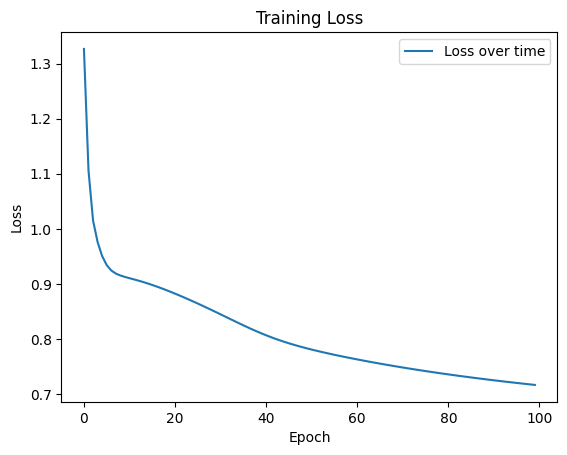

In [ ]:
# # import numpy as np
# # import matplotlib.pyplot as plt

# # # Helper functions
# # def linear_forward(x, W, b):
# #     return np.dot(x, W) + b

# # def batch_norm_forward(x, gamma, beta, epsilon=1e-5):
# #     mean = np.mean(x, axis=0)
# #     variance = np.var(x, axis=0)
# #     x_normalized = (x - mean) / np.sqrt(variance + epsilon)
# #     return gamma * x_normalized + beta, x_normalized, mean, variance

# # def tanh(x):
# #     return np.tanh(x)

# # def cross_entropy_loss(logits, targets):
# #     exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
# #     softmax = exps / np.sum(exps, axis=1, keepdims=True)
# #     n = targets.shape[0]
# #     loss = -np.sum(np.log(softmax[np.arange(n), targets])) / n
# #     return loss, softmax

# # # Define forward pass
# # def forward_pass(x, params):
# #     z1 = linear_forward(x, params['W1'], params['b1'])
# #     bn1, x_norm1, mean1, var1 = batch_norm_forward(z1, params['gamma1'], params['beta1'])
# #     a1 = tanh(bn1)

# #     z2 = linear_forward(a1, params['W2'], params['b2'])
# #     bn2, x_norm2, mean2, var2 = batch_norm_forward(z2, params['gamma2'], params['beta2'])

# #     loss, softmax_output = cross_entropy_loss(bn2, params['targets'])

# #     cache = {
# #         'x': x, 'z1': z1, 'a1': a1, 'z2': z2, 'softmax_output': softmax_output,
# #         'x_norm1': x_norm1, 'mean1': mean1, 'var1': var1,
# #         'x_norm2': x_norm2, 'mean2': mean2, 'var2': var2
# #     }
# #     return loss, cache

# # # Backpropagation functions
# # def cross_entropy_backward(softmax_output, targets):
# #     n = softmax_output.shape[0]
# #     softmax_output[np.arange(n), targets] -= 1
# #     softmax_output /= n
# #     return softmax_output

# def tanh_backward(a):
#     return 1 - a ** 2

# def backward_pass(cache, params):
#     grads = {}
#     dout = cross_entropy_backward(cache['softmax_output'], params['targets'])

#     grads['gamma2'] = np.sum(dout * cache['x_norm2'], axis=0)
#     grads['beta2'] = np.sum(dout, axis=0)

#     d_bn2 = dout * params['gamma2']

#     grads['W2'] = np.dot(cache['a1'].T, d_bn2)
#     grads['b2'] = np.sum(d_bn2, axis=0)

#     d_a1 = np.dot(d_bn2, params['W2'].T)
#     d_bn1 = d_a1 * tanh_backward(cache['a1'])

#     grads['gamma1'] = np.sum(d_bn1 * cache['x_norm1'], axis=0)
#     grads['beta1'] = np.sum(d_bn1, axis=0)

#     grads['W1'] = np.dot(cache['x'].T, d_bn1)
#     grads['b1'] = np.sum(d_bn1, axis=0)

#     return grads

# # Gradient descent update
# def update_params(params, grads, learning_rate=0.01):
#     params['W1'] -= learning_rate * grads['W1']
#     params['b1'] -= learning_rate * grads['b1']
#     params['gamma1'] -= learning_rate * grads['gamma1']
#     params['beta1'] -= learning_rate * grads['beta1']
#     params['W2'] -= learning_rate * grads['W2']
#     params['b2'] -= learning_rate * grads['b2']
#     params['gamma2'] -= learning_rate * grads['gamma2']
#     params['beta2'] -= learning_rate * grads['beta2']

# # Training the model
# def train(x, targets, params, epochs=100, learning_rate=0.01):
#     losses = []
#     params['targets'] = targets

#     for epoch in range(epochs):
#         # Forward pass
#         loss, cache = forward_pass(x, params)
#         losses.append(loss)

#         # Backward pass
#         grads = backward_pass(cache, params)

#         # Update parameters
#         update_params(params, grads, learning_rate)

#         # Print loss every 10 epochs
#         if epoch % 10 == 0:
#             print(f'Epoch {epoch}, Loss: {loss}')

#     # Visualization of loss
#     plt.plot(losses, label="Loss over time")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.title("Training Loss")
#     plt.legend()
#     plt.show()

# # Example usage
# input_size = 4
# hidden_size = 5
# output_size = 3
# x = np.random.randn(10, input_size)  # Batch of 10 examples
# targets = np.array([0, 1, 2, 1, 0, 2, 1, 0, 2, 1])  # Example target classes

# # Initialize parameters
# params = {
#     'W1': np.random.randn(input_size, hidden_size) * 0.01,
#     'b1': np.zeros(hidden_size),
#     'gamma1': np.ones(hidden_size),
#     'beta1': np.zeros(hidden_size),
#     'W2': np.random.randn(hidden_size, output_size) * 0.01,
#     'b2': np.zeros(output_size),
#     'gamma2': np.ones(output_size),
#     'beta2': np.zeros(output_size)
# }

# # Train the model and visualize loss
# train(x, targets, params, epochs=100, learning_rate=0.01)


Epoch 0, Loss: 1.7450578212738037
Epoch 10, Loss: 1.1947824954986572
Epoch 20, Loss: 0.955807089805603
Epoch 30, Loss: 0.8792129755020142
Epoch 40, Loss: 0.8361631631851196
Epoch 50, Loss: 0.8051878809928894
Epoch 60, Loss: 0.7798237800598145
Epoch 70, Loss: 0.7576080560684204
Epoch 80, Loss: 0.7374648451805115
Epoch 90, Loss: 0.7188315391540527


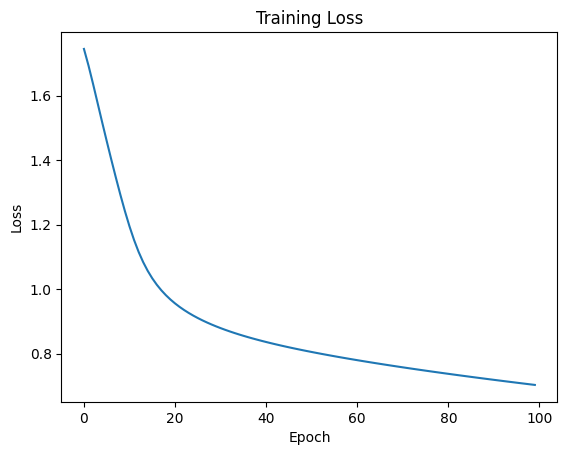

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the MLP Model
# class TwoLayerMLP(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(TwoLayerMLP, self).__init__()
#         self.layer1 = nn.Linear(input_size, hidden_size)
#         self.batch_norm1 = nn.BatchNorm1d(hidden_size)
#         self.tanh = nn.Tanh()
#         self.layer2 = nn.Linear(hidden_size, output_size)
#         self.batch_norm2 = nn.BatchNorm1d(output_size)

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.batch_norm1(x)
#         x = self.tanh(x)
#         x = self.layer2(x)
#         x = self.batch_norm2(x)
#         return x

# # Hyperparameters
# input_size = 4
# hidden_size = 5
# output_size = 3
# learning_rate = 0.01
# epochs = 100

# # Initialize model, loss, and optimizer
# model = TwoLayerMLP(input_size, hidden_size, output_size)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# # Generate some example data
# x = torch.randn(10, input_size)  # Batch of 10 examples
# targets = torch.randint(0, output_size, (10,))  # Random target classes

# # Training loop
# losses = []
# for epoch in range(epochs):
#     optimizer.zero_grad()
#     outputs = model(x)
#     loss = criterion(outputs, targets)
#     loss.backward()
#     optimizer.step()
#     losses.append(loss.item())

#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')

# # Plot the loss
# plt.plot(losses)
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training Loss")
# plt.show()
